In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
labenc = LabelEncoder()
mmscal = MinMaxScaler()
df['age'] = mmscal.fit_transform(df[['age']])
df['cp'] = mmscal.fit_transform(df[['cp']])
df['trtbps'] = mmscal.fit_transform(df[['trtbps']])
df['chol'] = mmscal.fit_transform(df[['chol']])
df['thalachh'] = mmscal.fit_transform(df[['thalachh']])
df = df.drop(columns=['fbs', 'restecg', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'])
df.head()

,age,sex,cp,trtbps,chol,thalachh
0,0.708333,1,1.000000,0.481132,0.244292,0.603053
1,0.166667,1,0.666667,0.339623,0.283105,0.885496
2,0.250000,0,0.333333,0.339623,0.178082,0.770992
3,0.562500,1,0.333333,0.245283,0.251142,0.816794
4,0.583333,0,0.000000,0.245283,0.520548,0.702290


In [4]:
# Название колонки целевого признака
TARGET_ATTRIBUTE = 'cp'
# Отделили колонку целевого признака (y_train)
X_df, y_df = df.drop(columns=[TARGET_ATTRIBUTE]), df[[TARGET_ATTRIBUTE]]
# Разделили выборку на тренировочную и тестовую
X_test, X_train, y_test, y_train = train_test_split(X_df, y_df)
# Присоединили колонку целевого признака к тренировочной выборке
X_train[TARGET_ATTRIBUTE] = y_train
# Переименовали переменную с тренировочными данными
TRAINING = X_train
# Массив с названиями колонок
ALL_COLUMNS = [col for col in TRAINING]
TRAINING

c:\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,age,sex,trtbps,chol,thalachh,cp
273,0.604167,1,0.056604,0.246575,0.648855,0.000000
106,0.833333,1,0.622642,0.246575,0.458015,1.000000
275,0.479167,1,0.292453,0.196347,0.740458,0.000000
114,0.541667,1,0.339623,0.310502,0.641221,0.333333
78,0.479167,1,0.320755,0.180365,0.862595,0.333333
...,...,...,...,...,...,...
0,0.708333,1,0.481132,0.244292,0.603053,1.000000
157,0.125000,1,0.264151,0.150685,0.786260,0.333333
158,0.604167,1,0.292453,0.214612,0.557252,0.333333
50,0.458333,0,0.339623,0.296804,0.595420,0.666667


In [5]:
# Расстояние между двумя точками
def dist(p: np.ndarray, q: np.ndarray):
    return math.sqrt(sum([(pv - qv) ** 2 for pv, qv in zip(p, q)]))

# Построение графиков с тестовым значением и найденными соседями
def plot_neighbours(X: pd.Series, neighbours: pd.DataFrame):
    X_dff = pd.DataFrame(X).T
    X_dff[TARGET_ATTRIBUTE] = -1
    axis_couples = []
    for i in range(len(ALL_COLUMNS) - 1):
        for j in range(i + 1, len(ALL_COLUMNS) - 1):
            axis_couples += [(ALL_COLUMNS[i], ALL_COLUMNS[j])]
    for x1, x2 in axis_couples:
        fig, ax = plt.subplots()
        sns.scatterplot(ax=ax, x=x1, y=x2, data=neighbours, hue=TARGET_ATTRIBUTE, palette=['#0000ff', '#ff0000', '#00ff00', '#00ffff'])
        sns.scatterplot(ax=ax, x=x1, y=x2, data=X_dff, hue=TARGET_ATTRIBUTE, palette=['#000000'], marker='X', s=200)

# Поиск соседей в тренировочных данных
def get_neighbors(K: int, X: pd.Series):
    X_array = X.to_numpy()        
    return pd.DataFrame.from_records(sorted(TRAINING.to_numpy(), key=lambda x: dist(x[:-1], X_array))[0:K], columns=ALL_COLUMNS)

# Предсказание категориального целевого признака по соседям
def predict_one(X: pd.Series, neighbours: pd.DataFrame):
    neighbours = [(dist(val[:-1], X.to_numpy()), val[-1]) for val in neighbours.to_numpy()]
    unique, counts = np.unique([val[1] for val in neighbours], return_counts=True)
    return sorted(np.c_[unique, counts], key=lambda x: x[1])[-1][0]


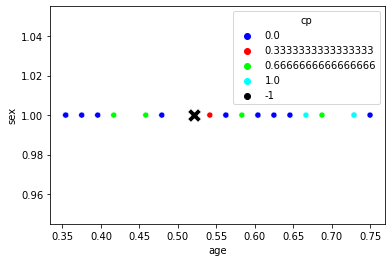

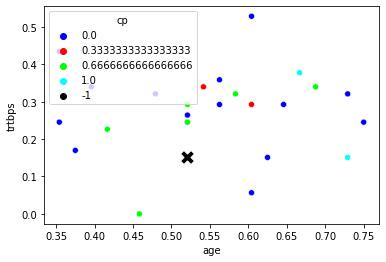

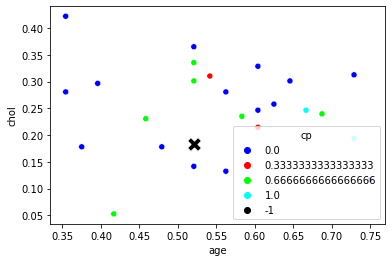

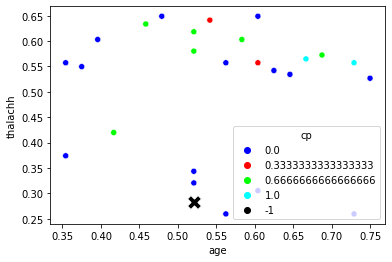

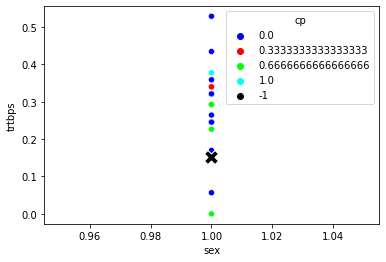

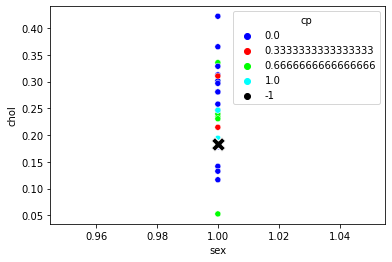

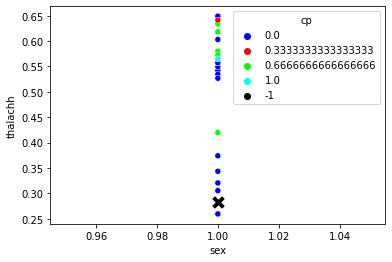

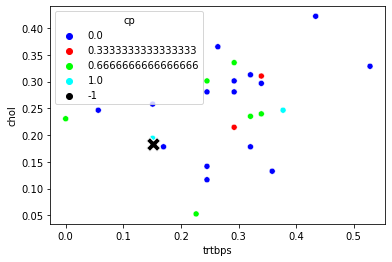

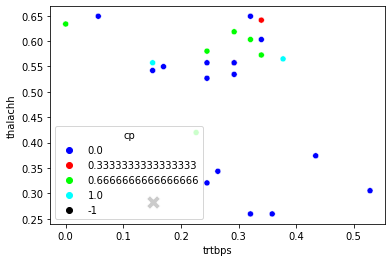

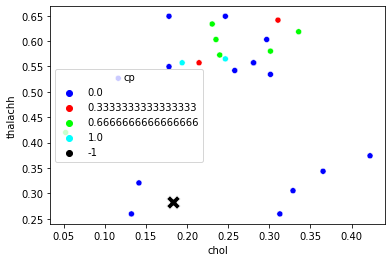

In [6]:
X_neighborss = []

# Для каждой строки в тестовой выборке находим 25 соседей 
for index, X in X_test.iterrows():
    neighborss = get_neighbors(25, X)
    X_neighborss += [(X, neighborss)]

# Выбираем первое значение тестовой выборки и его значение, затем рисуем графики с ними
plot_neighbours(X_neighborss[0][0], X_neighborss[0][1])

In [7]:
# Предсказание для первого значения тестовой выборки
pred = predict_one(X_neighborss[0][0], X_neighborss[0][1])
pred

0.0

In [8]:
# Добавляем в тестовую выборку столбец с предсказанными значениями
pred = pd.DataFrame(columns=ALL_COLUMNS)
for X, neighbours in X_neighborss:
    X[f'{TARGET_ATTRIBUTE}_pred'] = predict_one(X, neighbours)
    pred = pred.append(X)
pred[TARGET_ATTRIBUTE] = y_test

In [9]:
pred.head()

,age,sex,trtbps,chol,thalachh,cp,cp_pred
264,0.520833,1.0,0.150943,0.182648,0.282443,0.0,0.000000
262,0.500000,1.0,0.273585,0.356164,0.183206,0.0,0.000000
300,0.812500,1.0,0.471698,0.152968,0.534351,0.0,0.000000
289,0.541667,0.0,0.320755,0.180365,0.450382,0.0,0.666667
261,0.479167,1.0,0.169811,0.237443,0.679389,0.0,0.000000


In [10]:
# Вычисляем точность предсказаний
count = len(pred)
count_true = 0
index = 0
for index, X in pred.iterrows():
    if X[TARGET_ATTRIBUTE] == X[f'{TARGET_ATTRIBUTE}_pred']:
        count_true += 1
accuracy_manual = count_true / count
accuracy_manual

0.44052863436123346

In [11]:
# Находим оптимальное значение k с помощью RandomizedSearchCV
class NewRandomizedSearchCV(RandomizedSearchCV):
    def fit(self, X, y=None):
        return super(NewRandomizedSearchCV, self).fit(X, y)
#     def transform(self, X, y=None):
#         return super(NewRandomizedSearchCV, self).transform(X)
#     def fit_transform(self, X, y=None):
#         return super(NewRandomizedSearchCV, self).fit(X).transform(X)
    
knn = KNeighborsClassifier()
k_range = list(range(1, 30))
param_grid = dict(n_neighbors=k_range)

rnd = NewRandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# rnd = preprocessing. LabelEncoder ()
random_search=rnd.fit(X=X_train.to_numpy(), y=y_train.to_numpy().flatten())
best_K = random_search.best_params_['n_neighbors']
best_K

c:\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python36\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "c:\python36\lib\site-packages\sklearn\neighbors\_base.py", line 381, in _fit
    check_classification_targets(y)
  File "c:\python36\lib\site-packages\sklearn\utils\multiclass.py", line 183, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
c:\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on thi

ValueError: Unknown label type: 'continuous'

In [ ]:
# Находим соседей, проводим предсказания и вычисляем точность предсказаний для значения k, полученного с помощью RandomizedSearchCV
X_neighbours = []

for index, X in X_test.iterrows():
    neighbours = get_neighbors(best_K, X)
    X_neighbours += [(X, neighbours)]

pred = pd.DataFrame(columns=ALL_COLUMNS)
for X, neighbours in X_neighbours:
    X[f'{TARGET_ATTRIBUTE}_pred'] = predict_one(X, neighbours)
    pred = pred.append(X)
pred[TARGET_ATTRIBUTE] = y_test

count = len(pred)
count_true = 0
index = 0
for index, X in pred.iterrows():
    if X[TARGET_ATTRIBUTE] == X[f'{TARGET_ATTRIBUTE}_pred']:
        count_true += 1
accuracy_rs = count_true / count
accuracy_rs